# 🏠 부동산 실거래가 예측 대회 - KKH - EDA
> - 데이터를 분석해보자.
> - kimkihong / helpotcreator@gmail.com / Upstage AI Lab 3기
> - 2024.07.16.화 ~ 2024.07.19.금 19:00

In [54]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(fname=r'font/NanumGothic.otf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import math

# Model
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder

import eli5
from eli5.sklearn import PermutationImportance


# 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

In [55]:
train = pd.read_csv('data/kkh_train.csv', encoding='utf-8')
test = pd.read_csv('data/kkh_test.csv', encoding='utf-8')
subway = pd.read_csv('data/subway_feature.csv', encoding='utf-8')
bus = pd.read_csv('data/bus_feature.csv', encoding='utf-8')
kb = pd.read_csv('data/jaemyung_kb.csv', encoding='utf-8')
loan = pd.read_csv('data/kkh_loan.csv', encoding='utf-8') # 서울시 가계대출규모
# 서울시 가계대출규모 출처:  https://data.seoul.go.kr/dataList/10339/S/2/datasetView.do

## KB 부동산 지수 정보를 추가한다.

In [56]:
train = pd.merge(train, kb, left_on='계약년월', right_on='date', how='left')
train = train.drop(columns=['date'])

test = pd.merge(test, kb, left_on='계약년월', right_on='date', how='left')
test = test.drop(columns=['date'])

## 서울시 가계대출규모 정보를 추가한다.

- 2008년 포함하여 2023년 12월까지 자료이다.
- 따라서, train 데이터에서 계약년월이 200701 ~ 200712 에는 결측치가 발생할 것이다.

In [57]:
loan.sample(2)

,년월,서울시_가계대출
50,201203,200579.4
188,202309,407049.7


In [58]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   년월        192 non-null    int64  
 1   서울시_가계대출  192 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.1 KB


In [59]:
# '계약년월'과 '년월'이 일치하는 경우 '서울시_가계대출' 정보를 train에 병합
train = train.merge(loan, how='left', left_on='계약년월', right_on='년월')
# '년월' 열은 필요 없으므로 삭제
train.drop(columns=['년월'], inplace=True)

In [60]:
test = test.merge(loan, how='left', left_on='계약년월', right_on='년월')
test.drop(columns=['년월'], inplace=True)

In [61]:
train.sample(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target,구,동,좌표X,좌표Y,동+아파트명,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,5분이하_역_개수,5분초과_10분이하_역_개수,kb부동산지수,서울시_가계대출
90047,서울특별시 은평구 역촌동,31-6,31.0,6.0,아그네스풍림아이원,88.01,201803,14,5,2009,진흥로1길 28,NaN,,-,-,NaN,023888867,023888782,NaN,분양,위탁관리,계단식,개별난방,1.0,64.0,풍림산업,서부종합시장(주),2009-09-30 00:00:00.0,18427.0,6602.0,12639.0,0.0,0.0,64.0,NaN,NaN,2022-07-25 17:40:40.0,2024-07-11 08:06:14.0,NaN,위탁,단일계약,위탁,1972.28,64.0,기타,2024-04-16 11:15:44.0,Y,N,2024-04-16 10:33:51.0,45500,은평구,역촌동,126.918964,37.602986,역촌동 아그네스풍림아이원,역촌,6호선,474.095941,0,2,103.9,285382.6
812310,서울특별시 서초구 반포동,18-1,18.0,1.0,래미안퍼스티지,117.12,201401,28,9,2009,반포대로 275,NaN,,-,-,아파트,025999960,25999935.0,NaN,기타,위탁관리,계단식,지역난방,28.0,2444.0,삼성물산,반포주공2단지재건축조합,2009-07-14 00:00:00.0,540103.0,279426.0,279426.0,512.0,955.0,130.0,NaN,bpfirstige.aptner.com/,NaN,2023-09-23 16:19:01.0,114-82-63178-0,위탁,종합계약,위탁,16981.06,4368.0,의무,2016-01-12 11:48:03.0,Y,Y,2013-03-07 09:46:56.0,187000,서초구,반포동,126.999261,37.502932,반포동 래미안퍼스티지,신반포,9호선,299.115668,1,3,29.7,202891.1


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118822 entries, 0 to 1118821
Data columns (total 62 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [63]:
train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '단지신청일', 'target', '구', '동', '좌표X', '좌표Y', '동+아파트명', '1번째_가까운_역_이름',
       '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수',
       'kb부동산지수', '서울시_가계대출'],
      dtype='object')

In [64]:
print((train.isnull().mean() * 100).to_string())

시군구                        0.000000
번지                         0.020110
본번                         0.006703
부번                         0.006703
아파트명                       0.190021
전용면적(㎡)                    0.000000
계약년월                       0.000000
계약일                        0.000000
층                          0.000000
건축년도                       0.000000
도로명                        0.000000
해제사유발생일                   99.465241
등기신청일자                     0.000000
거래유형                       0.000000
중개사소재지                     0.000000
k-단지분류(아파트,주상복합등등)        77.822120
k-전화번호                    22.518327
k-팩스번호                    23.309070
단지소개기존clob                80.389284
k-세대타입(분양형태)              22.559889
k-관리방식                    22.559889
k-복도유형                    22.568380
k-난방방식                    22.506440
k-전체동수                    22.677959
k-전체세대수                   22.484274
k-건설사(시공사)                22.874863
k-시행사                     22.917944
k-사용검사일-사용승인일             22

## 테스트 데이터 확인

In [65]:
test.sample(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,좌표X,좌표Y,구,동,동+아파트명,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,5분이하_역_개수,5분초과_10분이하_역_개수,kb부동산지수,서울시_가계대출
743,서울특별시 강동구 고덕동,688,688.0,0.0,래미안힐스테이트고덕,84.83,202308,22,20,2016,아리수로50길 50,NaN,,중개거래,서울 강동구,NaN,024818729,024818732,NaN,기타,위탁관리,계단식,지역난방,51.0,3658.0,"삼성, 현대",고덕시영아파트 주택재건축사업조합,2016-12-29 00:00:00.0,673476.0,289808.0,396458.0,1074.0,2105.0,472.0,NaN,rhgd.aptner.com/v2,2017-04-18 05:55:51.0,2024-07-11 19:55:22.0,91711936281,위탁,종합계약,위탁,0.0,0.0,의무,2019-05-29 18:30:03.0,Y,N,2017-04-18 05:55:51.0,127.147102,37.558958,강동구,고덕동,고덕동 래미안힐스테이트고덕,고덕,5호선,761.225313,0,0,46.0,406315.8
1166,서울특별시 강동구 천호동,528,528.0,0.0,천호동삼성,114.65,202307,5,1,1997,성안로25길 6,NaN,20230922,중개거래,서울 강동구,NaN,024878518,024878584,77.0,분양,위탁관리,혼합식,개별난방,3.0,396.0,삼성물산(주),삼성물산(주),1997-05-26 00:00:00.0,49295.0,33635.0,33635.0,140.0,138.0,118.0,NaN,NaN,NaN,2024-07-11 20:38:51.0,3178273784,위탁,단일계약,위탁,2593.0,504.0,의무,2017-03-29 09:52:51.0,Y,N,2013-03-07 09:46:30.0,127.135257,37.538718,강동구,천호동,천호동 천호동삼성,강동,5호선,406.055831,0,2,38.0,404538.4


In [66]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9272 entries, 0 to 9271
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   시군구                     9272 non-null   object 
 1   번지                      9272 non-null   object 
 2   본번                      9272 non-null   float64
 3   부번                      9272 non-null   float64
 4   아파트명                    9272 non-null   object 
 5   전용면적(㎡)                 9272 non-null   float64
 6   계약년월                    9272 non-null   int64  
 7   계약일                     9272 non-null   int64  
 8   층                       9272 non-null   int64  
 9   건축년도                    9272 non-null   int64  
 10  도로명                     9272 non-null   object 
 11  해제사유발생일                 212 non-null    float64
 12  등기신청일자                  9272 non-null   object 
 13  거래유형                    9272 non-null   object 
 14  중개사소재지                  9272 non-null   

In [67]:
test.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '단지신청일', '좌표X', '좌표Y', '구', '동', '동+아파트명', '1번째_가까운_역_이름',
       '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수',
       'kb부동산지수', '서울시_가계대출'],
      dtype='object')

## 지하철 데이터 확인

In [68]:
subway.head(2)

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930


## 버스 데이터 확인

In [69]:
bus.head(2)

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로


## train 피처 세부 분석

In [70]:
def eda_kkh(df: pd.DataFrame):
    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] /len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc = pd.concat([desc, df.describe().T.drop('count',axis=1)],axis=1)
    return desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
        .bar(subset=['mean'],color='green')\
        .bar(subset=['max'],color='red')\
        .bar(subset=['min'], color='purple')

eda_kkh(train)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
계약년월,int64,1118822,198,0.017697,0,0.000000,201476.036448,418.786766,200701.000000,201110.000000,201507.000000,201804.000000,202306.000000
계약일,int64,1118822,31,0.002771,0,0.000000,15.806557,8.721166,1.000000,8.000000,16.000000,23.000000,31.000000
층,int64,1118822,73,0.006525,0,0.000000,8.871968,5.982584,-4.000000,4.000000,8.000000,12.000000,69.000000
건축년도,int64,1118822,60,0.005363,0,0.000000,1998.755327,9.333908,1961.000000,1992.000000,2000.000000,2005.000000,2023.000000
target,int64,1118822,14530,1.298687,0,0.000000,57991.532149,46426.021936,350.000000,30500.000000,44800.000000,69800.000000,1450000.000000
5분이하_역_개수,int64,1118822,6,0.000536,0,0.000000,0.298455,0.542652,0.000000,0.000000,0.000000,1.000000,5.000000
5분초과_10분이하_역_개수,int64,1118822,9,0.000804,0,0.000000,0.964697,1.129041,0.000000,0.000000,1.000000,1.000000,8.000000
전용면적(㎡),float64,1118822,14617,1.306463,0,0.000000,77.174747,29.364231,10.020000,59.650000,81.880000,84.960000,424.320000
좌표X,float64,1118822,8924,0.797625,0,0.000000,126.998075,0.090792,126.806100,126.918782,127.019655,127.066837,127.180795
좌표Y,float64,1118822,8922,0.797446,0,0.000000,37.555203,0.057079,37.434454,37.506860,37.547779,37.600742,37.687660


## test 피처 세부 분석

In [71]:
eda_kkh(test)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
계약년월,int64,9272,3,0.032355,0,0.000000,202307.786238,0.733229,202307.000000,202307.000000,202308.000000,202308.000000,202309.000000
계약일,int64,9272,31,0.334340,0,0.000000,14.967429,8.802402,1.000000,8.000000,15.000000,22.000000,31.000000
층,int64,9272,54,0.582399,0,0.000000,10.021031,6.653698,-3.000000,5.000000,9.000000,14.000000,65.000000
건축년도,int64,9272,57,0.614754,0,0.000000,2003.034944,11.179837,1961.000000,1996.000000,2003.000000,2012.000000,2023.000000
5분이하_역_개수,int64,9272,5,0.053926,0,0.000000,0.313417,0.545345,0.000000,0.000000,0.000000,1.000000,5.000000
5분초과_10분이하_역_개수,int64,9272,9,0.097066,0,0.000000,0.976381,1.116735,0.000000,0.000000,1.000000,1.000000,8.000000
본번,float64,9272,1175,12.672563,0,0.000000,615.101920,592.812553,0.000000,234.750000,509.000000,816.000000,4974.000000
부번,float64,9272,121,1.305004,0,0.000000,5.676553,53.852248,0.000000,0.000000,0.000000,0.000000,2164.000000
전용면적(㎡),float64,9272,2590,27.933563,0,0.000000,75.414506,29.343517,12.000000,59.700000,76.570000,84.960000,301.470000
좌표X,float64,9272,2587,27.901208,0,0.000000,126.998408,0.089126,126.807146,126.920916,127.017939,127.065430,127.180795


## 본격적인 EDA

In [72]:
train['계약년'] = train['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
train['계약월'] = train['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

test['계약년'] = test['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
test['계약월'] = test['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

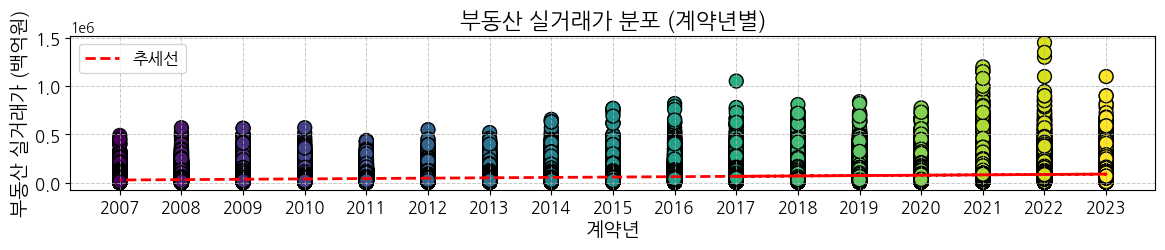

In [73]:
# 데이터 준비: '계약년'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['계약년', 'target']].dropna()

# 색상 맵 설정
cmap = plt.get_cmap('viridis')

# '계약년'의 범위를 0에서 1 사이로 정규화하여 색상에 매핑
norm = plt.Normalize(data['계약년'].min(), data['계약년'].max())

# 회귀 분석
coefficients = np.polyfit(data['계약년'], data['target'], 1)  # 1차 다항식(직선) 회귀
polynomial = np.poly1d(coefficients)
regression_line = polynomial(data['계약년'])

# 그래프 그리기
plt.figure(figsize=(14, 2))
scatter = plt.scatter(data['계약년'], data['target'], c=data['계약년'], cmap=cmap, norm=norm, s=100, edgecolor='black')

# 추세선 그리기
plt.plot(data['계약년'], regression_line, color='red', linewidth=2, linestyle='--', label='추세선')

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포 (계약년별)', fontsize=16, fontweight='bold')
plt.xlabel('계약년', fontsize=14)
plt.ylabel('부동산 실거래가 (백억원)', fontsize=14)

# x축 눈금 설정
years = sorted(data['계약년'].unique())
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)

# 그리드 및 범례 설정
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

# 차트 표시
plt.show()


###  == 위 차트 분석 결과 ==

- 모든 부동산 거래내역을 년도별로 표시한 차트임.
- 최고 가격으로 거래된 건은 2022년도에 분포함.

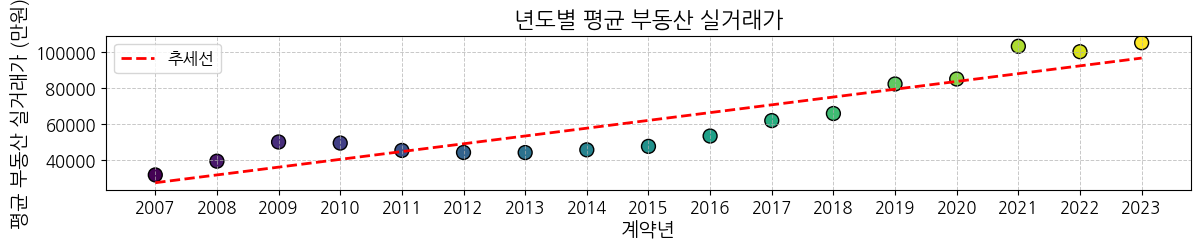

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 준비: '계약년'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['계약년', 'target']].dropna()

# 년도별 평균 가격 계산
yearly_avg_price = data.groupby('계약년')['target'].mean().sort_index()

# 색상 맵 설정
cmap = plt.get_cmap('viridis')

# '계약년'의 범위를 0에서 1 사이로 정규화하여 색상에 매핑
norm = plt.Normalize(yearly_avg_price.index.min(), yearly_avg_price.index.max())

# 회귀 분석
coefficients = np.polyfit(yearly_avg_price.index, yearly_avg_price.values, 1)  # 1차 다항식(직선) 회귀
polynomial = np.poly1d(coefficients)
regression_line = polynomial(yearly_avg_price.index)

# 그래프 그리기
plt.figure(figsize=(14, 2))
scatter = plt.scatter(yearly_avg_price.index, yearly_avg_price.values, c=yearly_avg_price.index, cmap=cmap, norm=norm, s=100, edgecolor='black')

# 추세선 그리기
plt.plot(yearly_avg_price.index, regression_line, color='red', linewidth=2, linestyle='--', label='추세선')

# 제목 및 축 레이블 설정
plt.title('년도별 평균 부동산 실거래가', fontsize=16, fontweight='bold')
plt.xlabel('계약년', fontsize=14)
plt.ylabel('평균 부동산 실거래가 (만원)', fontsize=14)

# x축 눈금 설정
years = sorted(yearly_avg_price.index)
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)

# 그리드 및 범례 설정
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

# 차트 표시
plt.show()


###  == 위 차트 분석 결과 ==

- 년도별로 부동산 실거래가의 평균을 구분한 차트임.
- 국소적으로 하락 하기도 했으나, 전반적으로는 상승 추세임.
- 계약년도와 target(부동산 실거래가)는 양의 상관관계로 보임.

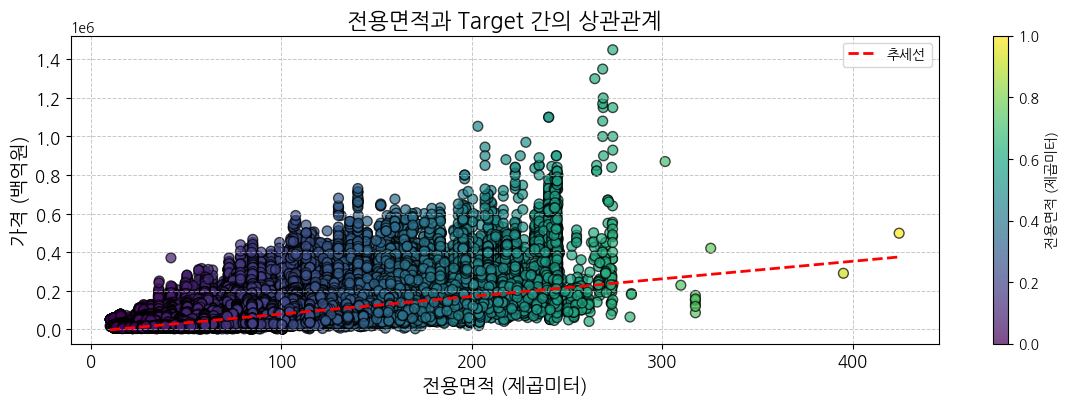

In [75]:
# 데이터 준비: 'area'와 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['전용면적(㎡)', 'target']].dropna()

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data['전용면적(㎡)'].min(), data['전용면적(㎡)'].max())
colors = cmap(norm(data['전용면적(㎡)']))

plt.figure(figsize=(14, 4))
scatter = plt.scatter(data['전용면적(㎡)'], data['target'], c=colors, s=50, edgecolor='black', alpha=0.7)

coefficients = np.polyfit(data['전용면적(㎡)'], data['target'], 1)  # 1차 선형 회귀
polynomial = np.poly1d(coefficients)
x_values = np.linspace(data['전용면적(㎡)'].min(), data['전용면적(㎡)'].max(), 100)
y_values = polynomial(x_values)

plt.plot(x_values, y_values, color='red', linestyle='--', linewidth=2, label='추세선')
plt.title('전용면적과 Target 간의 상관관계', fontsize=16, fontweight='bold')
plt.xlabel('전용면적 (제곱미터)', fontsize=14)
plt.ylabel('가격 (백억원)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar = plt.colorbar(scatter, label='전용면적 (제곱미터)', orientation='vertical')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

###  == 위 차트 분석 결과 ==

- 일반적으로, 전용면적이 클 수록 target(부동산 실거래가) 값이 높음.
- 전용면적과 target 값은 양의 상관관계로 보임.

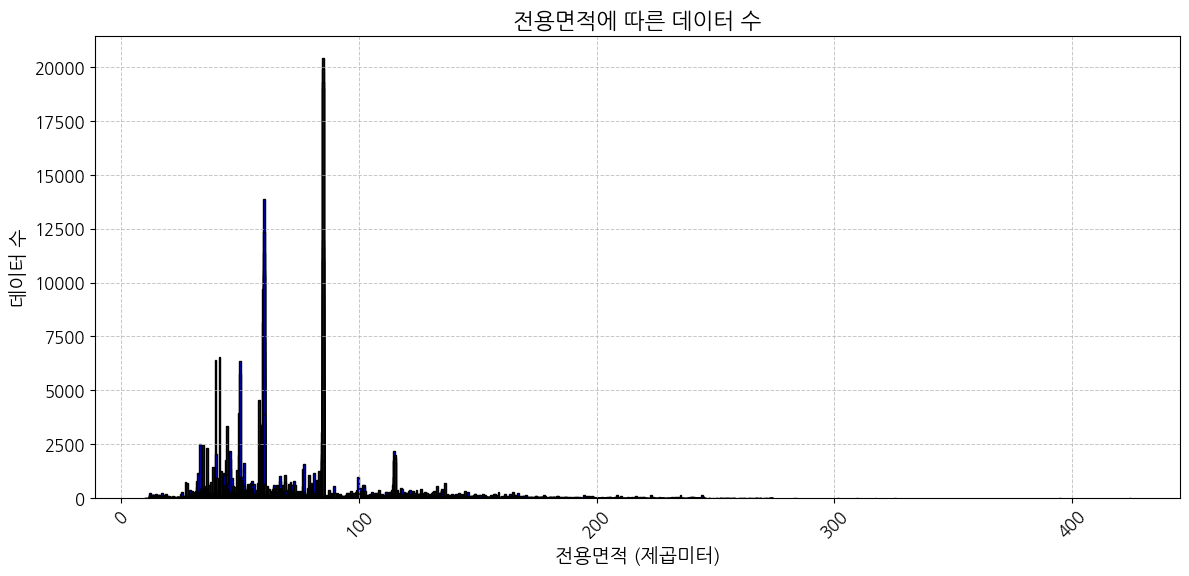

In [76]:
# 데이터 준비: 'area'와 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['전용면적(㎡)']].dropna()

# 전용면적별 데이터 수를 계산합니다.
area_counts = data['전용면적(㎡)'].value_counts().sort_index()

# 라인 차트를 그립니다.
plt.figure(figsize=(14, 6))
plt.bar(area_counts.index, area_counts.values, color='b', edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('전용면적에 따른 데이터 수', fontsize=16, fontweight='bold')
plt.xlabel('전용면적 (제곱미터)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12, rotation=45)  # x축 레이블을 더 잘 보이도록 회전
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

###  == 위 차트 분석 결과 ==

- 국민 평수로 불리우는 84㎡ 및 59㎡ 부근의 데이터가 가장 많아 보임.
- 해당 부근을 확대해보자.

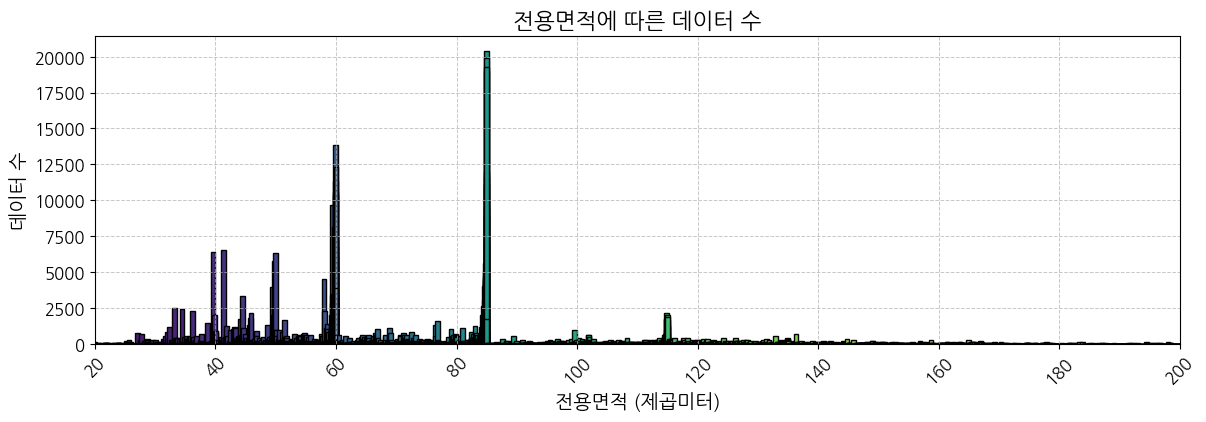

In [77]:
# 데이터 준비: 'area'와 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['전용면적(㎡)']].dropna()

# 전용면적별 데이터 수를 계산합니다.
area_counts = data['전용면적(㎡)'].value_counts().sort_index()

# 색상 맵 선택 (viridis, plasma, inferno, magma, etc.)
cmap = plt.get_cmap('viridis')

# 각 막대의 색상을 색상 맵에서 가져오기
colors = cmap(np.linspace(0, 1, len(area_counts)))

plt.figure(figsize=(14, 4))
bars = plt.bar(area_counts.index, area_counts.values, color=colors, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('전용면적에 따른 데이터 수', fontsize=16, fontweight='bold')
plt.xlabel('전용면적 (제곱미터)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12, rotation=45)  # x축 레이블을 더 잘 보이도록 회전
plt.yticks(fontsize=12)

# x축 범위 설정
plt.xlim(20, 200)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

###  == 위 차트 분석 결과 ==

- 59㎡(±1) 및 84㎡(±1) 면적이 전체 데이터에서 차지하는 비율: 약 53%
- 90㎡ 이하의 면적이 전체 데이터에서 차지하는 비율: 약 83%
- 비슷한 값을 그룹화 하여 분석할 필요가 보임.

In [78]:
# 전용면적 범위 필터링
area_filtered = train[(58 <= train['전용면적(㎡)']) & (train['전용면적(㎡)'] <= 60) |
                      (83 <= train['전용면적(㎡)']) & (train['전용면적(㎡)'] <= 85)]

# 전체 데이터 개수와 필터링된 데이터 개수
total_count = len(train)
filtered_count = len(area_filtered)

# 비율 계산
percentage = (filtered_count / total_count) * 100

print(f'면적이 58~60㎡ 및 83~85㎡인 데이터의 비율: {percentage:.2f}%')

면적이 58~60㎡ 및 83~85㎡인 데이터의 비율: 52.64%


In [79]:
# 전용면적 범위 필터링
area_filtered = train[(train['전용면적(㎡)'] <= 90)]
total_count = len(train)
filtered_count = len(area_filtered)
percentage = (filtered_count / total_count) * 100
print(f'면적이 90㎡ 이하인 데이터의 비율: {percentage:.2f}%')

면적이 90㎡ 이하인 데이터의 비율: 82.92%


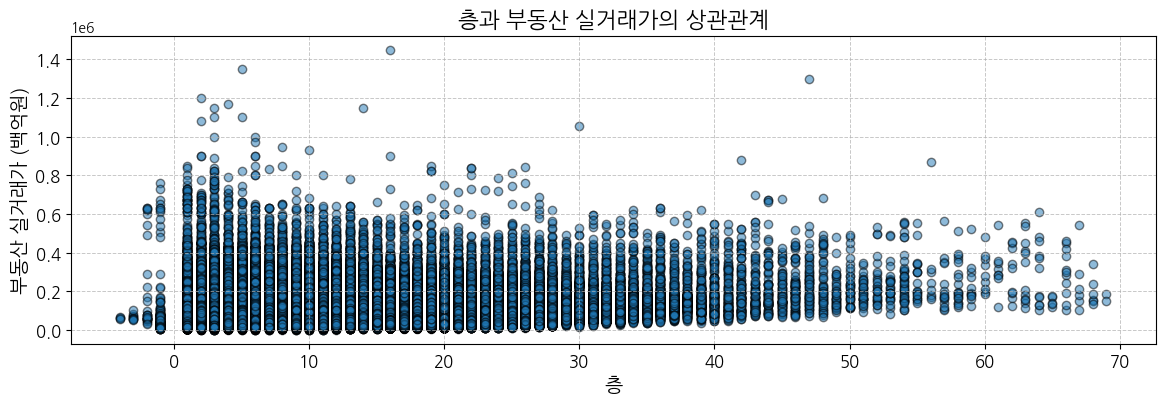

In [80]:
# 데이터 준비: '층'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['층', 'target']].dropna()

plt.figure(figsize=(14, 4))
plt.scatter(data['층'], data['target'], alpha=0.5, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('층과 부동산 실거래가의 상관관계', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('부동산 실거래가 (백억원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()


###  == 위 차트 분석 결과 ==

- 층 피처를 본 차트로 분석했을 때는, 특별한 특징을 추출하기 어려움.
- 다만, 층이 높아질 수록, 저렴한 부동산은 사라짐이 보임.
- 더욱 심도있는 분석이 필요함.

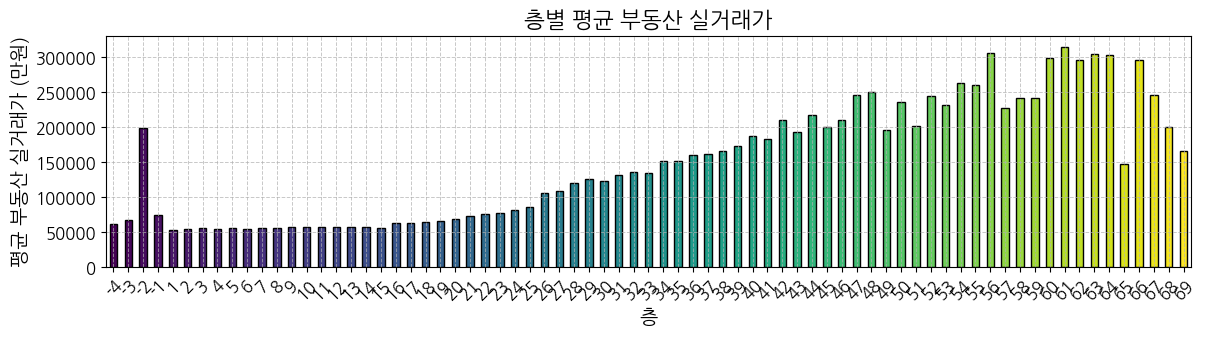

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비: '층'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['층', 'target']].dropna()

# 층별 평균 거래가를 계산합니다.
mean_prices_per_floor = data.groupby('층')['target'].mean()

# 색상 맵 선택 (viridis, plasma, inferno, magma, etc.)
cmap = plt.get_cmap('viridis')

# 각 막대의 색상을 색상 맵에서 가져오기
colors = cmap(np.linspace(0, 1, len(mean_prices_per_floor)))

plt.figure(figsize=(14, 3))
mean_prices_per_floor.plot(kind='bar', color=colors, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('층별 평균 부동산 실거래가', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('평균 부동산 실거래가 (만원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()


###  == 위 차트 분석 결과 ==

- 일반적으로, 층이 높을수록 부동산 가격이 높아지는 경향을 보임.
- 67층 이상의 고층에서 가격이 다시 하락하는 경향이 보이는데,
- 데이터 개수가 적으니, 경향성을 함부로 속단하기 어려운 부분임.
- (데이터 수:  67층_6개,  68층_6개,  69층_2개)

In [82]:
floor = 2
print(f'{floor}층 미만: ', train[(floor == train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean())
print(f'{floor}층 이상: ', train[(floor < train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean())

2층 미만:  53645.097589469995
2층 이상:  58679.398935340454


In [83]:
print(f'-4층: {train[train["층"] == -4].shape[0]}')
print(f'-3층: {train[train["층"] == -3].shape[0]}')
print(f'-2층: {train[train["층"] == -2].shape[0]}')
print(f'-1층: {train[train["층"] == -1].shape[0]}')
print(f'65층: {train[train["층"] == 65].shape[0]}')
print(f'66층: {train[train["층"] == 66].shape[0]}')
print(f'67층: {train[train["층"] == 67].shape[0]}')
print(f'68층: {train[train["층"] == 68].shape[0]}')
print(f'69층: {train[train["층"] == 69].shape[0]}')

-4층: 4
-3층: 10
-2층: 31
-1층: 216
65층: 5
66층: 11
67층: 6
68층: 6
69층: 2


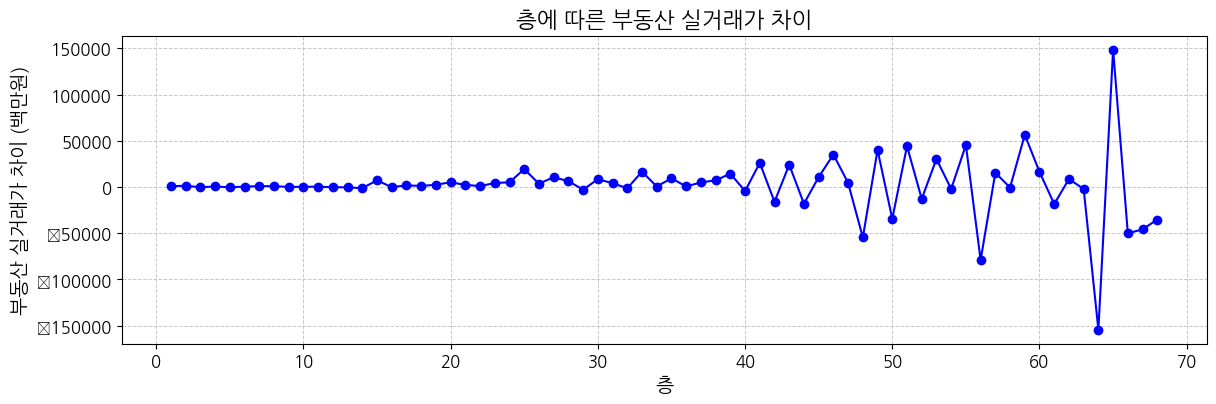

In [84]:
floor_diff_value_list = dict()
for floor in range(1, 100, 1):
    diff = train[((floor+1) == train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean() - train[(floor == train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean()
    if np.isnan(diff):
        break
    floor_diff_value_list[floor] = int(diff)


plt.figure(figsize=(14, 4))
plt.plot(floor_diff_value_list.keys(), floor_diff_value_list.values(), marker='o', linestyle='-', color='b')

# 제목 및 축 레이블 설정
plt.title('층에 따른 부동산 실거래가 차이', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('부동산 실거래가 차이 (백만원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

###  == 위 차트 분석 결과 ==

- 바로 아래층과 바로 윗층의 가격을 비교한 차트이다.
- 예를 들어, 30층을 기준으로 한다면, 30층과 29층의 가격차이를 비교한 것이다.
- 1개 층의 차이값이기에 큰 차이가 없어 보이다가, 40층 이상 부터는 가격 차이가 들죽날죽하다.

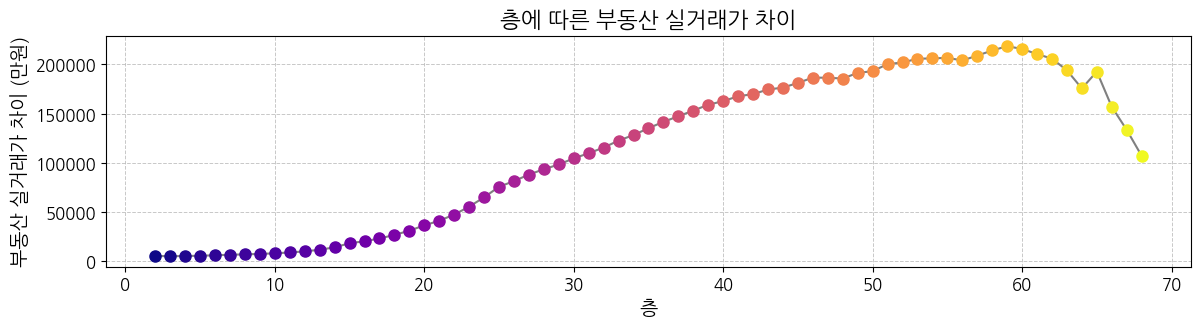

In [85]:
floor_diff_value_list = dict()
for floor in range(2, 100, 1):
    diff = train[(floor < train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean() - train[(floor >= train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean()
    if np.isnan(diff):
        break
    floor_diff_value_list[floor] = int(diff)


# 색상 맵 선택 (viridis, plasma, inferno, magma, etc.)
cmap = plt.get_cmap('plasma')

# 각 점의 색상을 색상 맵에서 가져오기
colors = cmap(np.linspace(0, 1, len(floor_diff_value_list)))

plt.figure(figsize=(14, 3))

# 라인 그리기
plt.plot(list(floor_diff_value_list.keys()), list(floor_diff_value_list.values()), marker='o', linestyle='-', color='gray')

# 각 점에 색상 적용
for i, (x, y) in enumerate(floor_diff_value_list.items()):
    plt.plot(x, y, marker='o', color=colors[i], markersize=8)

# 제목 및 축 레이블 설정
plt.title('층에 따른 부동산 실거래가 차이', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('부동산 실거래가 차이 (만원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

###  == 위 차트 분석 결과 ==

- 아래층 이하와 윗층 이상의 평균가격을 비교한 차트이다.
- 예를 들어, 30층을 기준으로 한다면, 30층 이상의 평균가격과  29층 이하의 평균가격 차이를 비교한 것이다.
- 60층 부터는 가격이 떨어지는 것처럼 보이는데, 데이터가 많이 없는 구간이라서 60층 이상은 본 차트만으로 속단하면 안 된다.

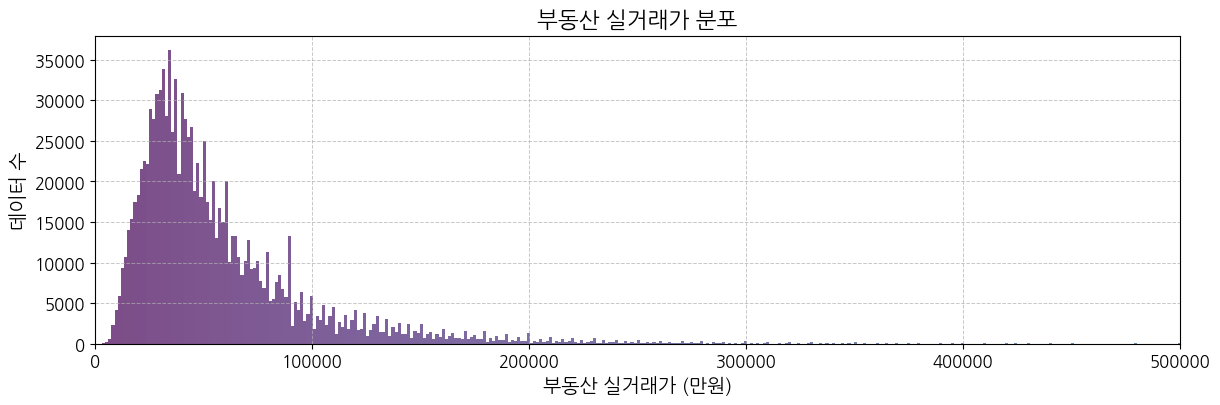

In [86]:
# 데이터 준비: 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['target']].dropna()

# 색상 맵 선택 (viridis)
cmap = plt.get_cmap('viridis')

# 데이터의 min과 max를 기준으로 색상 범위 정규화
norm = plt.Normalize(data['target'].min(), data['target'].max())

# 히스토그램 생성
plt.figure(figsize=(14, 4))
n, bin_edges, patches = plt.hist(data['target'], bins=1000, alpha=0.7)

# 색상 적용
for patch, edge in zip(patches, bin_edges[:-1]):
    color = cmap(norm(edge))
    patch.set_facecolor(color)

# x축 범위 설정
plt.xlim(0, 500000)

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포', fontsize=16, fontweight='bold')
plt.xlabel('부동산 실거래가 (만원)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

###  == 위 차트 분석 결과 ==

- target(부동산 실거래가) 값의 분포를 나타낸 차트임.
- 좌측으로 쏠려있고, 오른쪽으로 꼬리가 긴, 양의 왜도(Right skewed) 형태임.
- 20억 이상의 부동산은 데이터 양이 적으니, 예측이 어려울 것으로 예상됨.

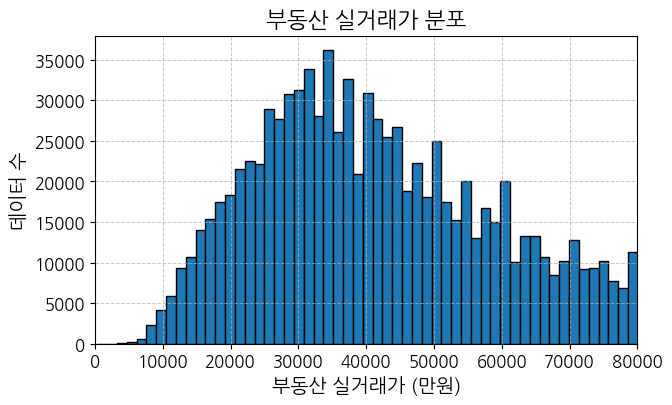

In [87]:
# 데이터 준비: 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['target']].dropna()

# 히스토그램을 생성합니다.
plt.figure(figsize=(7, 4))
plt.hist(data['target'], bins=1000, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포', fontsize=16, fontweight='bold')
plt.xlabel('부동산 실거래가 (만원)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 80000)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

### == 위 차트 분석 결과 ==

- 앞서 살펴보았던 차트에서, 가장 데이터가 많았던 부분만 확대한 차트이다.
- 3 ~ 4억 사이의 데이터가 가장 많음.

In [88]:
print('target의 max: ', train['target'].max())
print('target의 min: ', train['target'].min())

target의 max:  1450000
target의 min:  350


In [89]:
print(train[train['target'] < 1000])

                     시군구      번지      본번    부번   아파트명  전용면적(㎡)    계약년월  계약일  \
197746     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   88.930  200812    1   
197747     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197748     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197749     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197750     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197751     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197752     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197753     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197754     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197755     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197756     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197757     서울특별시 은평구 구산동  199-24   199.0  24.0     신

In [90]:
print('계약년월의 max: ', train['계약년월'].max())
print('계약년월의 min: ', train['계약년월'].min())

계약년월의 max:  202306
계약년월의 min:  200701


In [91]:
print('아파트 종류: ', len(train['아파트명'].unique()))
display(train['아파트명'].value_counts()[:10])

아파트 종류:  6539


현대       16644
신동아      12846
한신        9074
두산        8533
주공2       7918
우성        7768
벽산        7285
삼성래미안     7143
대림        6305
극동        5669
Name: 아파트명, dtype: int64

In [92]:
train['구'].value_counts()[:10]

노원구    115099
송파구     73785
강남구     69083
강서구     66610
강동구     61895
구로구     57604
성북구     56675
양천구     53977
서초구     53126
도봉구     52572
Name: 구, dtype: int64

In [93]:
train['동'].value_counts()[:10]

상계동    44948
중계동    26357
신정동    24038
창동     23101
구로동    22811
봉천동    20511
목동     17246
월계동    17056
서초동    15899
공릉동    15763
Name: 동, dtype: int64

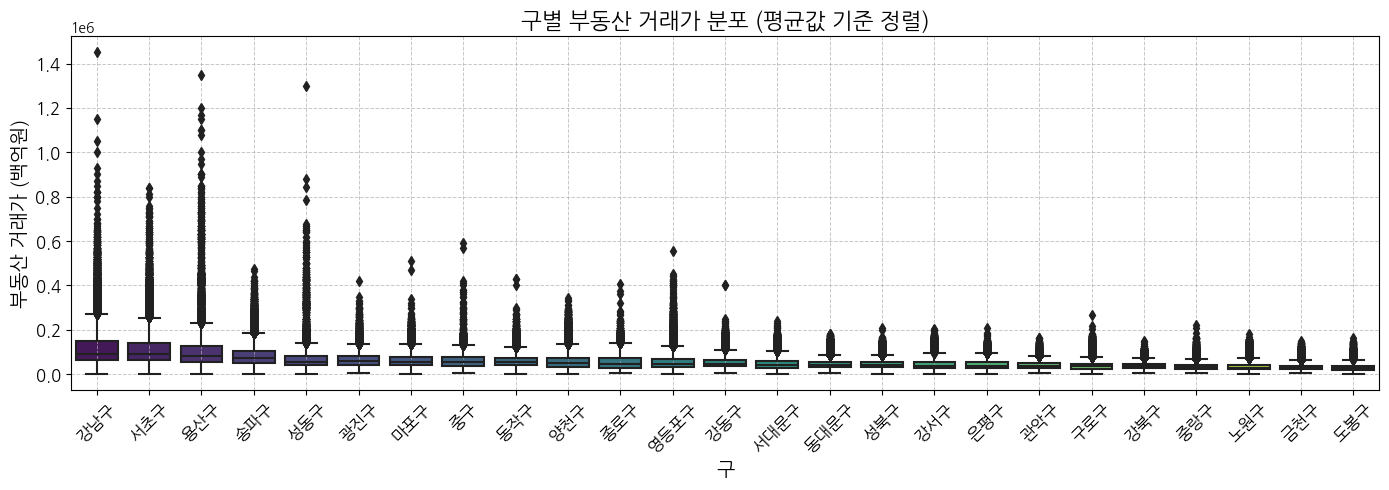

In [94]:
# '구' 피처별로 'target'의 평균값을 계산합니다.
mean_target_by_gu = train.groupby('구')['target'].mean().sort_values(ascending=False).reset_index()

# '구'별로 평균값이 높은 순서로 정렬된 데이터프레임을 생성합니다.
ordered_gu = mean_target_by_gu['구']

# 박스플롯을 그립니다.
plt.figure(figsize=(14, 5))

# seaborn의 boxplot을 사용하여 박스플롯 생성
sns.boxplot(x='구', y='target', data=train, order=ordered_gu, palette='viridis')

# 제목 및 축 레이블 설정
plt.xlabel('구', fontsize=14)
plt.ylabel('부동산 거래가 (백억원)', fontsize=14)
plt.title('구별 부동산 거래가 분포 (평균값 기준 정렬)', fontsize=16, fontweight='bold')

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()

### == 위 차트 분석 결과 ==

- 강남구, 서초구, 용산구, … 순서로 부동산 가격이 높음.
- 구 별로 부동산 가격 분포의 차이가 심함.
- ‘구’, ‘동’과 같은 주소 및 위치 정보가 target(부동산 실거래가) 값 예측에 중요하게 작용할 것으로 예상됨.


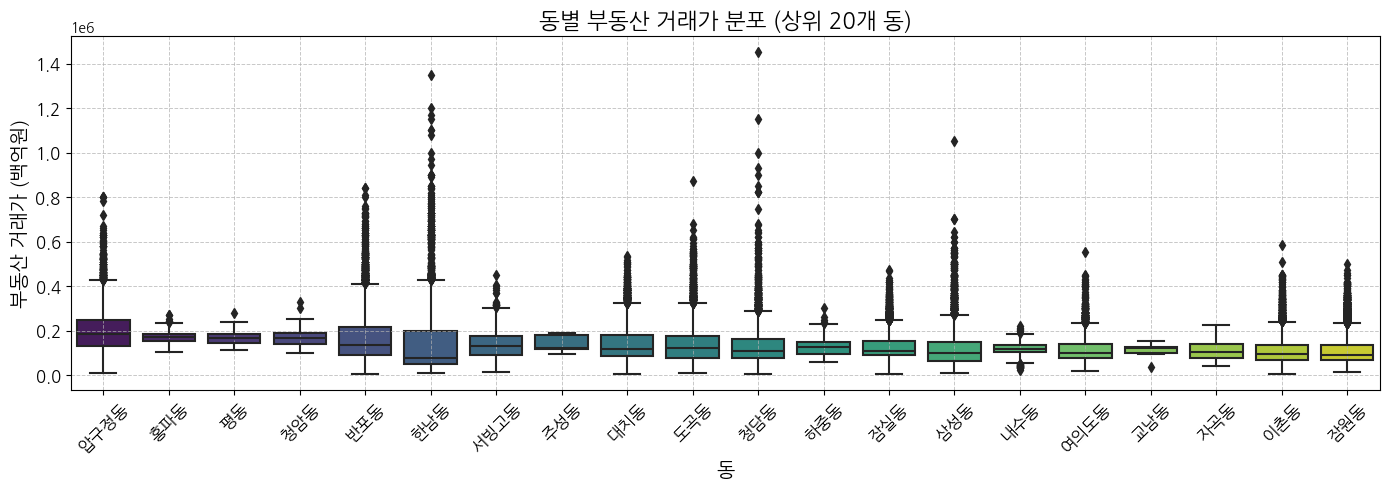

In [95]:
# '동'으로 끝나는 데이터만 필터링합니다.
dong_data = train[train['동'].str.endswith('동')]

# '동' 피처별로 'target'의 평균값을 계산합니다.
mean_target_by_dong = dong_data.groupby('동')['target'].mean().sort_values(ascending=False).reset_index()

# 평균값이 높은 순서로 상위 20개의 '동'을 선택합니다.
top_20_dong = mean_target_by_dong.head(20)['동']

# 상위 20개의 '동'에 해당하는 데이터만 필터링합니다.
filtered_train = dong_data[dong_data['동'].isin(top_20_dong)]

# 박스플롯을 그립니다.
plt.figure(figsize=(14, 5))

# seaborn의 boxplot을 사용하여 박스플롯 생성
sns.boxplot(x='동', y='target', data=filtered_train, order=top_20_dong, palette='viridis')

# 제목 및 축 레이블 설정
plt.xlabel('동', fontsize=14)
plt.ylabel('부동산 거래가 (백억원)', fontsize=14)
plt.title('동별 부동산 거래가 분포 (상위 20개 동)', fontsize=16, fontweight='bold')

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.tight_layout()  # 레이아웃 조정
plt.show()

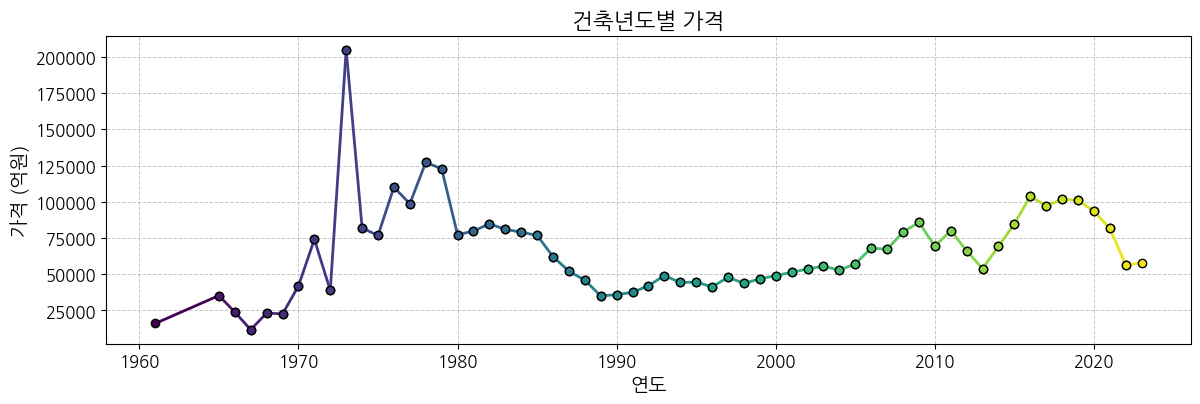

In [96]:
# 건축년도별 평균 가격 계산
train_yearly = train.groupby(train['건축년도'])['target'].mean()

# 색상 맵 선택
cmap = plt.get_cmap('viridis')

# 색상 맵에서 색상 가져오기
norm = plt.Normalize(train_yearly.index.min(), train_yearly.index.max())
colors = cmap(norm(train_yearly.index))

plt.figure(figsize=(14, 4))

# 선 그리기
for i in range(len(train_yearly) - 1):
    plt.plot(train_yearly.index[i:i+2], train_yearly.values[i:i+2], color=colors[i], linewidth=2, marker='o', markersize=6, markerfacecolor=colors[i], markeredgecolor='black')

# 제목 및 축 레이블 설정
plt.title('건축년도별 가격', fontsize=16, fontweight='bold')
plt.xlabel('연도', fontsize=14)
plt.ylabel('가격 (억원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

### == 위 차트 분석 결과 ==

- 1961년 ~ 2023년 사이에 건축된 다양한 부동산이 존재함.
- 최근 건축된 부동산이 오래된 부동산에 비해 상대적으로 높은 가격일 것으로 예상했지만,
건축년도 데이터만으로는 거래가격과의 경향성을 찾기 어려워 보임.
오히려, 다른 feature가 부동산 실거래가에 더 큰 영향을 줄 것으로 예상됨.
- 더불어, 오래된 부동산 중에 거래가가 굉장히 높은 부분이 보이는데, 1973년도 데이터이며, 한강변의 재건축 대상이면서도, 비싸기로 유명한 서초구 반포주공1단지 등의 부동산이 포함된 것으로 확인됨.

In [97]:
train.groupby('건축년도')['target'].mean().idxmax()

1973

In [98]:
train_1973 = train[train['건축년도'] == 1973]
train_1973_sorted = train_1973.sort_values(by='target', ascending=False)
display(train_1973_sorted)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target,구,동,좌표X,좌표Y,동+아파트명,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,5분이하_역_개수,5분초과_10분이하_역_개수,kb부동산지수,서울시_가계대출,계약년,계약월
232768,서울특별시 서초구 반포동,757,757.0,0.0,반포주공1단지,140.13,202209,6,3,1973,신반포로 9,NaN,,중개거래,서울 서초구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,730000,서초구,반포동,126.989053,37.505361,반포동 반포주공1단지,구반포,9호선,469.712909,0,2,24.9,412355.6,2022,9
232767,서울특별시 서초구 반포동,757,757.0,0.0,반포주공1단지,140.13,202209,3,5,1973,신반포로 9,NaN,,중개거래,서울 서초구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715000,서초구,반포동,126.989053,37.505361,반포동 반포주공1단지,구반포,9호선,469.712909,0,2,24.9,412355.6,2022,9
232761,서울특별시 서초구 반포동,757,757.0,0.0,반포주공1단지,140.13,202205,10,4,1973,신반포로 45,NaN,,중개거래,서울 서초구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710000,서초구,반포동,126.989053,37.505361,반포동 반포주공1단지,구반포,9호선,469.712909,0,2,59.7,411590.1,2022,5
232760,서울특별시 서초구 반포동,757,757.0,0.0,반포주공1단지,140.13,202205,10,4,1973,신반포로 45,20220627.0,,중개거래,서울 서초구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710000,서초구,반포동,126.989053,37.505361,반포동 반포주공1단지,구반포,9호선,469.712909,0,2,59.7,411590.1,2022,5
232763,서울특별시 서초구 반포동,757,757.0,0.0,반포주공1단지,140.13,202205,28,2,1973,신반포로 45,NaN,,중개거래,서울 서초구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,690000,서초구,반포동,126.989053,37.505361,반포동 반포주공1단지,구반포,9호선,469.712909,0,2,59.7,411590.1,2022,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104317,서울특별시 서대문구 홍제동,157-68,157.0,68.0,광산,53.52,200705,3,3,1973,모래내로 455,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9500,서대문구,홍제동,126.945421,37.585638,홍제동 광산,홍제,3호선,409.104469,0,2,NaN,NaN,2007,5
1114157,서울특별시 은평구 갈현동,467-2,467.0,2.0,역촌맨션,53.20,200704,10,4,1973,연서로19길 9,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9500,은평구,갈현동,126.916374,37.613648,갈현동 역촌맨션,구산,6호선,264.559062,1,0,NaN,NaN,2007,4
1104320,서울특별시 서대문구 홍제동,157-68,157.0,68.0,광산,52.53,200709,3,6,1973,모래내로 455,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8800,서대문구,홍제동,126.945421,37.585638,홍제동 광산,홍제,3호선,409.104469,0,2,NaN,NaN,2007,9
1104316,서울특별시 서대문구 홍제동,157-68,157.0,68.0,광산,52.53,200704,7,6,1973,모래내로 455,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8500,서대문구,홍제동,126.945421,37.585638,홍제동 광산,홍제,3호선,409.104469,0,2,NaN,NaN,2007,4


In [99]:
train['세대별주차대수'] = train['주차대수'] / train['k-전체세대수']
test['세대별주차대수'] = test['주차대수'] / test['k-전체세대수']

In [100]:
# '동+아파트명' 기준으로 그룹화하여 'target' 피처의 평균 가격 계산
mean_target_per_group = train.groupby('동+아파트명')['target'].mean()

# 평균 가격이 200,000 이상인 그룹을 리스트로 생성
high_price_groups = mean_target_per_group[mean_target_per_group >= 200000].index.tolist()

# train 데이터에 'top_apt' 피처 추가
train['top_apt'] = train['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

# test 데이터에 'top_apt' 피처 추가
test['top_apt'] = test['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

In [101]:
train['국민평수'] = train['전용면적(㎡)'].apply(lambda x: 1 if x <= 90 else 0)

In [102]:
selected_feature_list = ['아파트명', '전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '구', '동', '세대별주차대수', '좌표X', '좌표Y', 'target', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-135㎡초과']
train = train[selected_feature_list]

In [103]:
print((train.isnull().mean() * 100).to_string())

아파트명                       0.190021
전용면적(㎡)                    0.000000
서울시_가계대출                   5.252578
층                          0.000000
건축년도                       0.000000
구                          0.000000
동                          0.000000
세대별주차대수                   22.778333
좌표X                        0.000000
좌표Y                        0.000000
target                     0.000000
top_apt                    0.000000
국민평수                       0.000000
1번째_가까운_역_이름               0.000000
1번째_가까운_역_거리               0.000000
kb부동산지수                    5.252578
k-전용면적별세대현황(60㎡이하)        22.586167
k-전용면적별세대현황(60㎡~85㎡이하)    22.586167
k-135㎡초과                  99.970773


In [104]:
def impute_missing_values(df):
    # 수치형 피처와 범주형 피처 구분
    numeric_features = df.select_dtypes(include=[np.number]).columns
    categorical_features = df.select_dtypes(include=[object]).columns
    
    # 수치형 피처의 결측치를 평균값으로 대체
    # for feature in numeric_features:
    #     mean_value = df[feature].mean()
    #     df[feature].fillna(mean_value, inplace=True)
    
    # 수치형 피처의 결측치를 -999으로 대체
    for feature in numeric_features:
        df[feature].fillna(-999, inplace=True)
    
    # 범주형 피처의 결측치를 'Missing'으로 대체
    for feature in categorical_features:
        df[feature].fillna('Missing', inplace=True)
    
    return df

impute_missing_values(train)

,아파트명,전용면적(㎡),서울시_가계대출,층,건축년도,구,동,세대별주차대수,좌표X,좌표Y,target,top_apt,국민평수,1번째_가까운_역_이름,1번째_가까운_역_거리,kb부동산지수,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-135㎡초과
0,개포6차우성,79.97,282438.7,3,1987,강남구,개포동,0.970370,127.056859,37.476276,124000,0,1,구룡,1187.672025,88.4,20.0,250.0,-999.0
1,개포6차우성,79.97,282438.7,4,1987,강남구,개포동,0.970370,127.056859,37.476276,123500,0,1,구룡,1187.672025,88.4,20.0,250.0,-999.0
2,개포6차우성,54.98,282438.7,5,1987,강남구,개포동,0.970370,127.056859,37.476276,91500,0,1,구룡,1187.672025,88.4,20.0,250.0,-999.0
3,개포6차우성,79.97,283669.8,4,1987,강남구,개포동,0.970370,127.056859,37.476276,130000,0,1,구룡,1187.672025,118.0,20.0,250.0,-999.0
4,개포6차우성,79.97,283669.8,2,1987,강남구,개포동,0.970370,127.056859,37.476276,117000,0,1,구룡,1187.672025,118.0,20.0,250.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,갈현현대,59.94,-999.0,11,1998,은평구,구산동,1.000000,126.905543,37.612989,20000,0,1,구산,1048.367837,-999.0,171.0,141.0,-999.0
1118818,갈현현대,59.94,-999.0,10,1998,은평구,구산동,1.000000,126.905543,37.612989,20000,0,1,구산,1048.367837,-999.0,171.0,141.0,-999.0
1118819,갈현현대,84.83,-999.0,20,1998,은평구,구산동,1.000000,126.905543,37.612989,28000,0,1,구산,1048.367837,-999.0,171.0,141.0,-999.0
1118820,갈현현대,84.83,-999.0,8,1998,은평구,구산동,1.000000,126.905543,37.612989,29000,0,1,구산,1048.367837,-999.0,171.0,141.0,-999.0


In [105]:
print((train.isnull().mean() * 100).to_string())

아파트명                      0.0
전용면적(㎡)                   0.0
서울시_가계대출                  0.0
층                         0.0
건축년도                      0.0
구                         0.0
동                         0.0
세대별주차대수                   0.0
좌표X                       0.0
좌표Y                       0.0
target                    0.0
top_apt                   0.0
국민평수                      0.0
1번째_가까운_역_이름              0.0
1번째_가까운_역_거리              0.0
kb부동산지수                   0.0
k-전용면적별세대현황(60㎡이하)        0.0
k-전용면적별세대현황(60㎡~85㎡이하)    0.0
k-135㎡초과                  0.0


In [106]:
train = train[~train['층'].isin([-2, 65, 67, 68, 69])]

In [107]:
# train = train[train['계약년월'] >= 201801]

In [115]:
train['국민평수'] = train['국민평수'].astype('category')

SEED = 1053682552

# TARGET 정의
TARGET = 'target'

# NUMERIC_COLS 계산: TARGET을 제외한 수치형 컬럼 리스트
NUMERIC_COLS = [col for col in train.select_dtypes(include=[float, int]).columns if col != TARGET]

# CAT_COLS 계산: NUMERIC_COLS를 제외한 나머지 컬럼 리스트
CAT_COLS = [col for col in train.columns if col not in NUMERIC_COLS + [TARGET]]

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')

Target         --> target
Numeric Cols   --> ['전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '세대별주차대수', '좌표X', '좌표Y', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-135㎡초과']
Categoric Cols --> ['아파트명', '구', '동', 'top_apt', '국민평수', '1번째_가까운_역_이름']


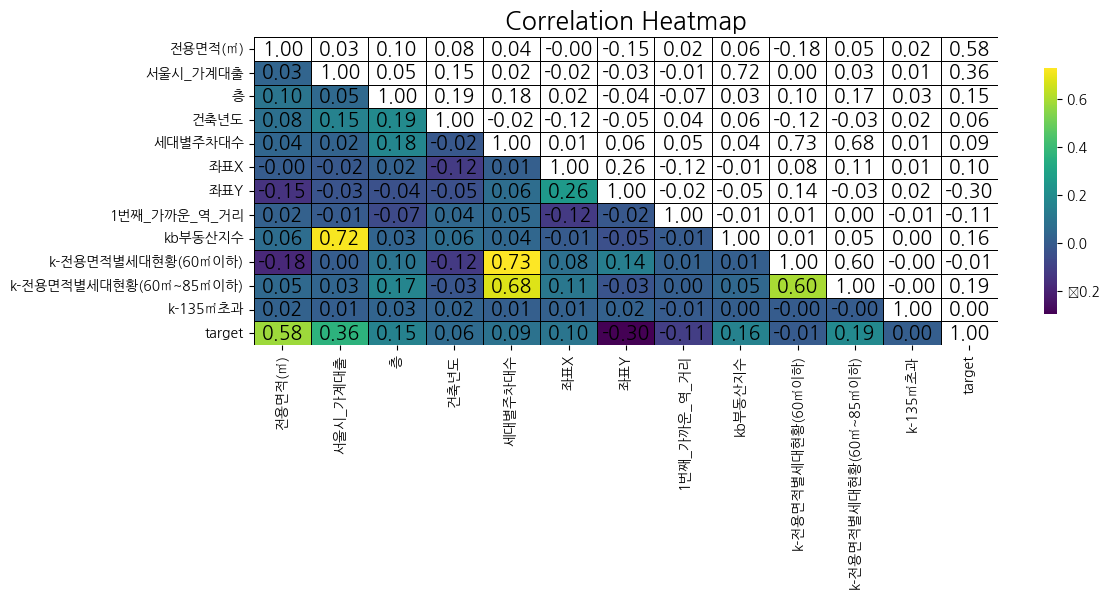

In [116]:
# 상관 행렬 계산
corr = train[NUMERIC_COLS + [TARGET]].corr()

# 마스크 생성
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
plt.figure(figsize=(12, 4))  # 그래프 크기 조정
ax = sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

# 각 셀에 숫자 추가
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black',  # 글자색 검은색
                fontsize=14,    # 글자 크기 조정
                fontweight='bold')  # 글자 굵게

# 타이틀 추가
plt.title('Correlation Heatmap', size=18)

# 그래프 표시
plt.show()

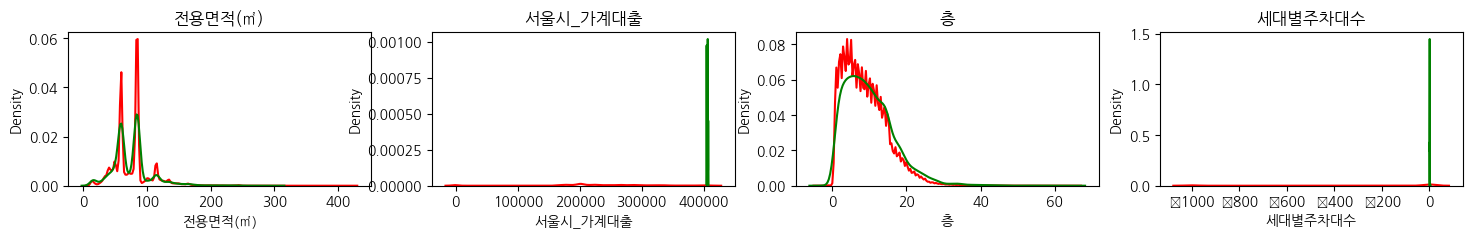

In [117]:
col_list = ['전용면적(㎡)', '서울시_가계대출', '층', '세대별주차대수']

n_cols = len(col_list)
n_rows = math.ceil(len(col_list)/n_cols)
fig, ax = plt.subplots(1,n_cols, figsize=(18, 2))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.2)
for i,c in enumerate(col_list):
    sns.kdeplot(train[c],color='red',ax=ax[i])
    sns.kdeplot(test[c],color='green',ax=ax[i])
    ax[i].set_title(f'{c}')
for j in range(len(col_list),len(ax)):
    ax[j].axis('off')
plt.show()
    

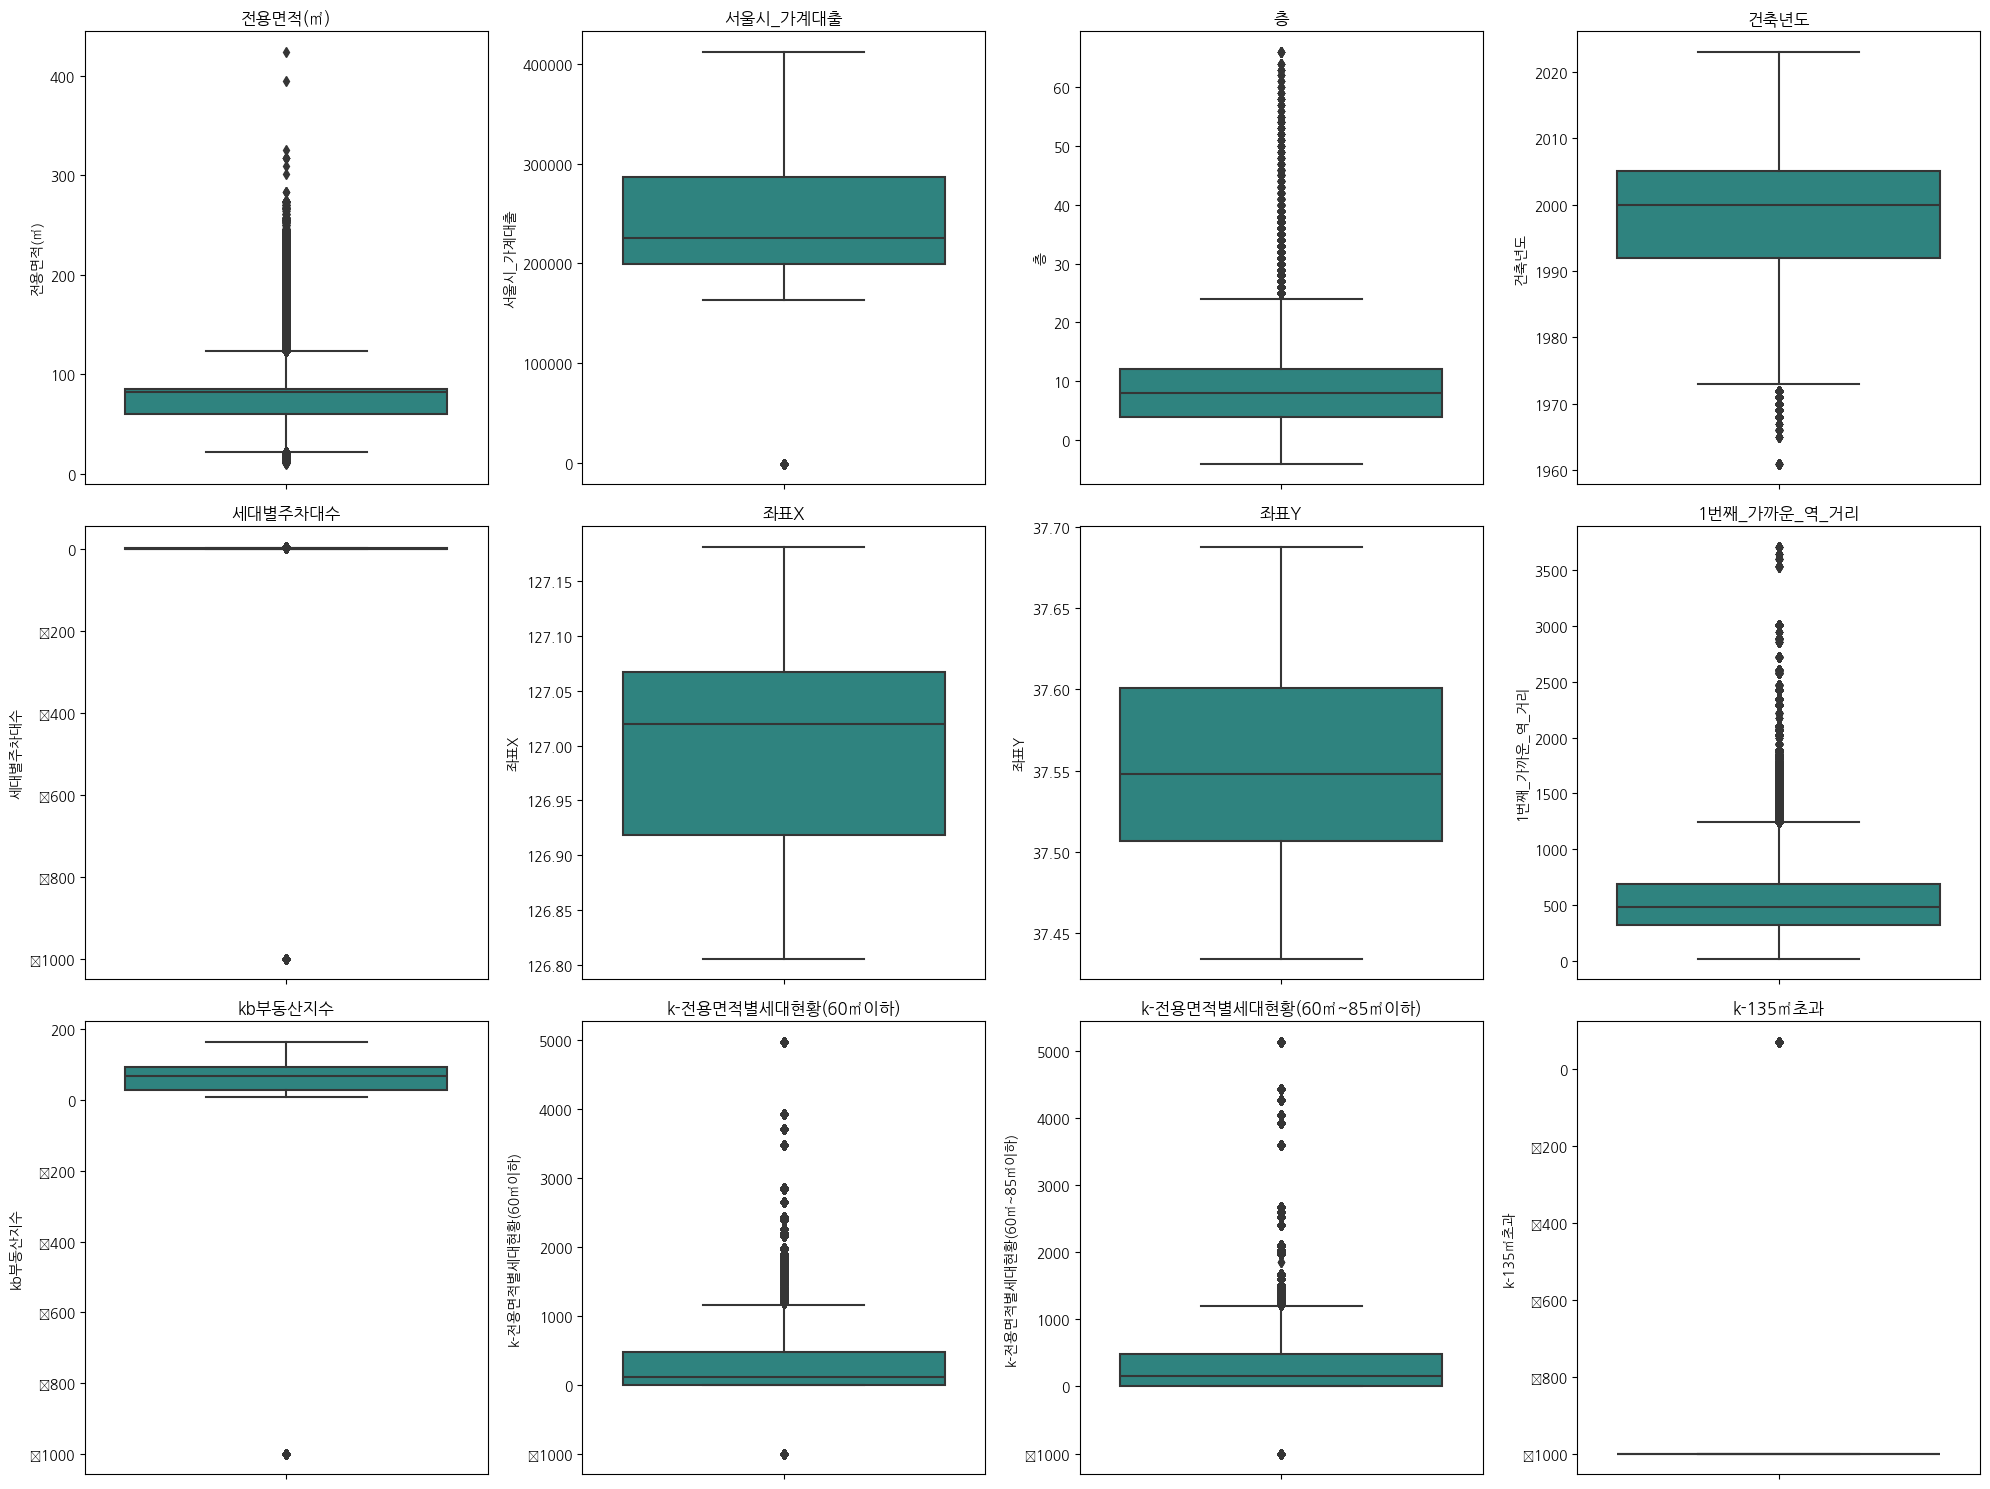

In [119]:
col_list = ['전용면적(㎡)', '서울시_가계대출', '층', '건축년도', '세대별주차대수', '좌표X', '좌표Y', '1번째_가까운_역_거리', 'kb부동산지수', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-135㎡초과']

# 수치형 피처들에 대한 박스 플롯 그리기
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# 각 수치형 피처에 대해 박스 플롯을 그립니다.
for ax, column in zip(axes.flatten(), col_list):
    sns.boxplot(data=train, y=column, ax=ax, palette="viridis")
    ax.set_title(f'{column}')

# 나머지 빈 플롯들 숨기기
for i in range(len(col_list), 3 * 4):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()